In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# use CUDA?
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

lr = 0.01
momentum = 0.5
batch_size = 256

In [18]:
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
#                        transforms.RandomRotation(10),
#                        transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

In [19]:
class Net(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [20]:
class Flatten(nn.Module):
    def __init__(self, size):
        super(Flatten, self).__init__()
        self.param_size = size
        
    def forward(self, x):
        return x.view(-1, self.param_size)
    

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [23]:
# autoencoder = Autoencoder().to(device)
optim = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

for epoch in range(10):
    losses = []
    pbar = tqdm(enumerate(train_loader), leave=False)
    for i, (data, target) in pbar:
        autoencoder.zero_grad()
        data = data.to(device)
        res = autoencoder(data)
        loss = criterion(res, data)
        loss.backward()
        losses.append(loss.item())
        pbar.set_description('loss is ' + str(loss.item()))
        optim.step()
    print(epoch, np.mean(losses))


0 0.45345653435


1 0.452325206107


2 0.45130295094


3 0.450274040471


KeyboardInterrupt: 

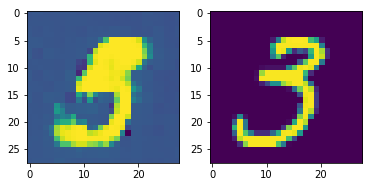

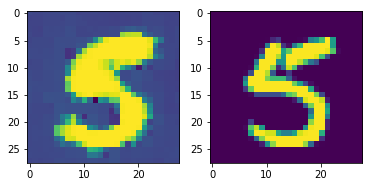

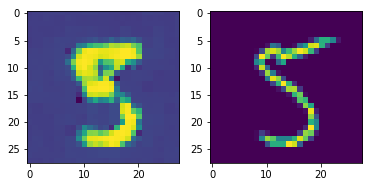

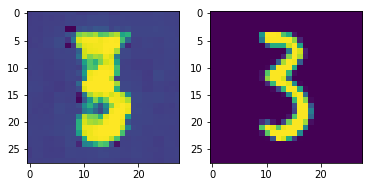

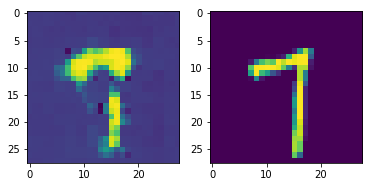

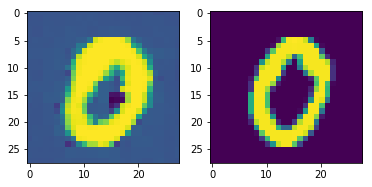

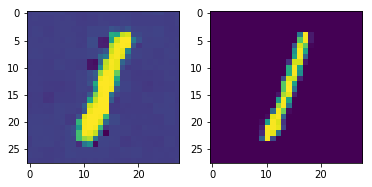

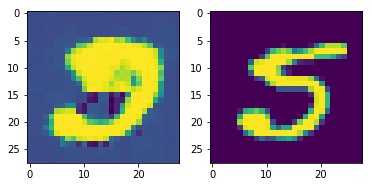

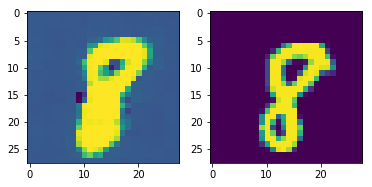

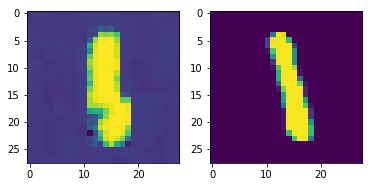

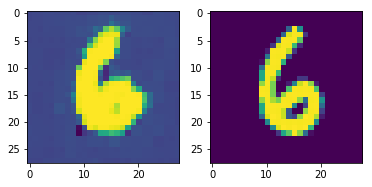

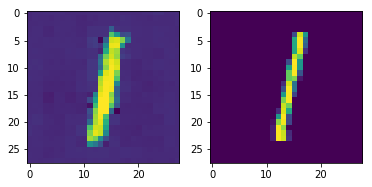

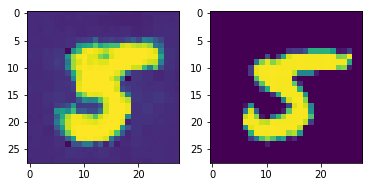

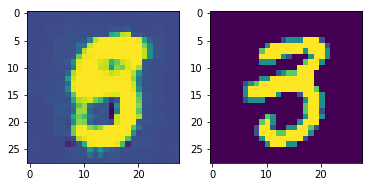

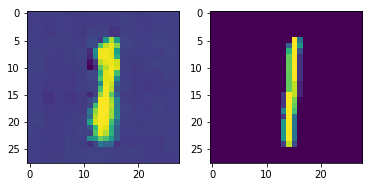

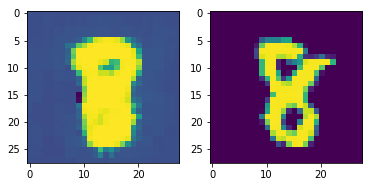

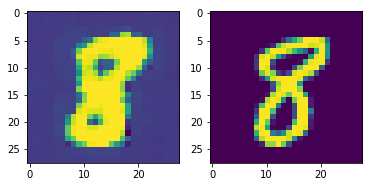

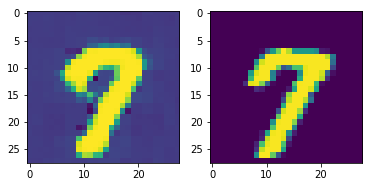

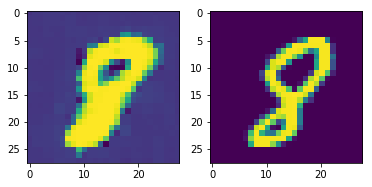

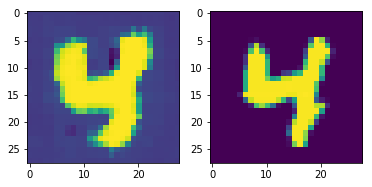

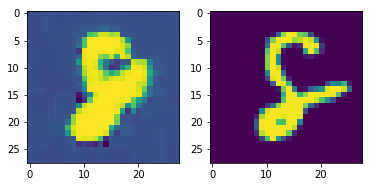

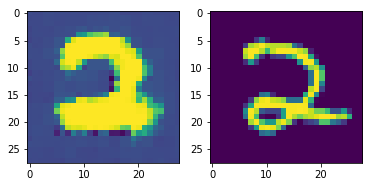

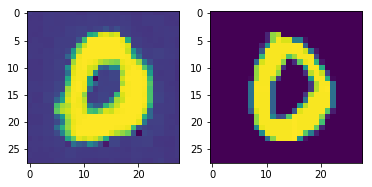

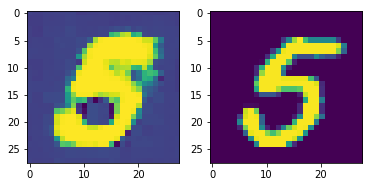

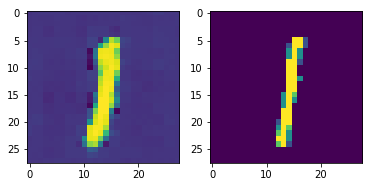

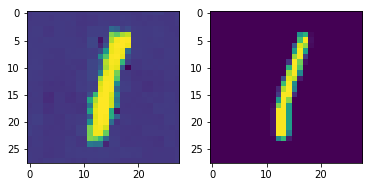

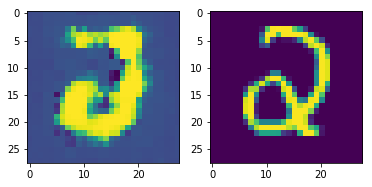

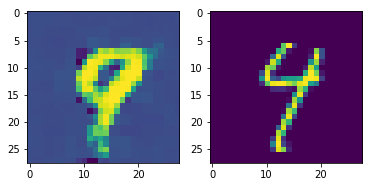

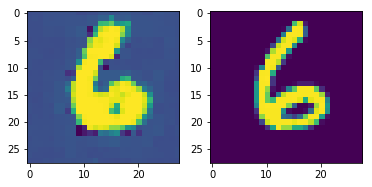

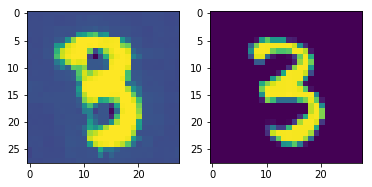

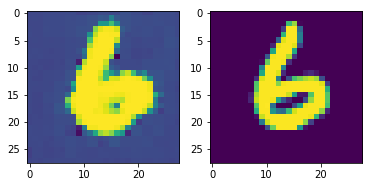

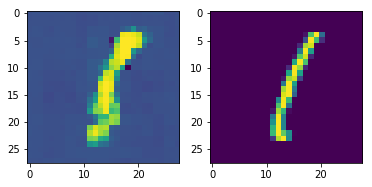

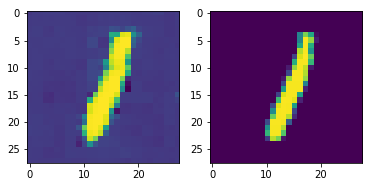

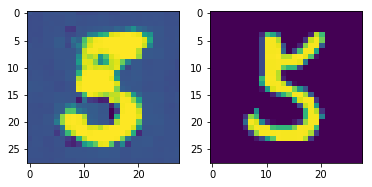

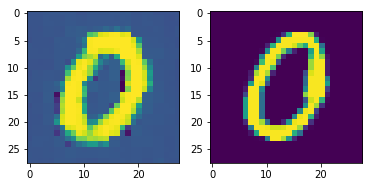

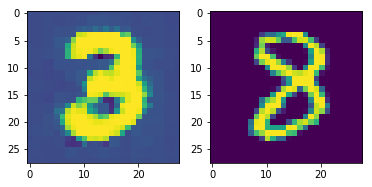

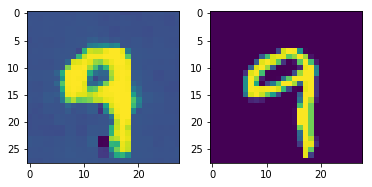

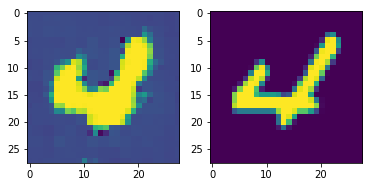

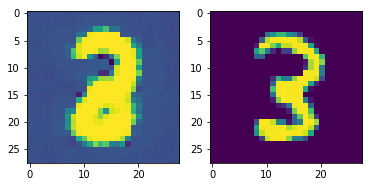

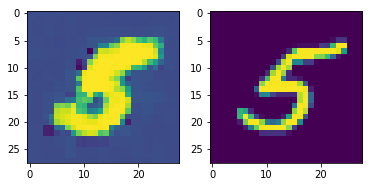

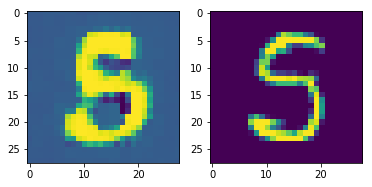

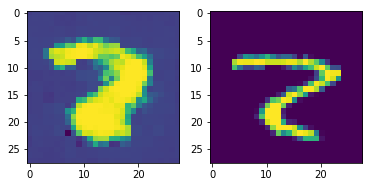

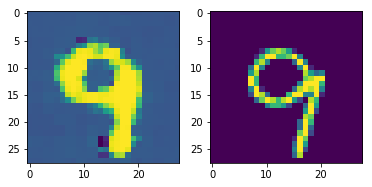

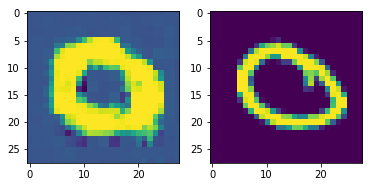

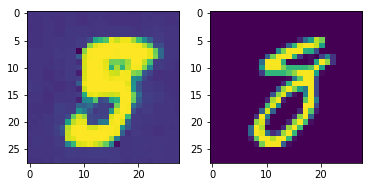

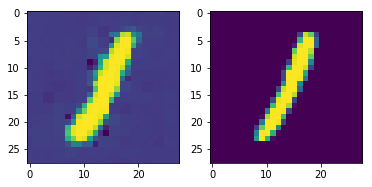

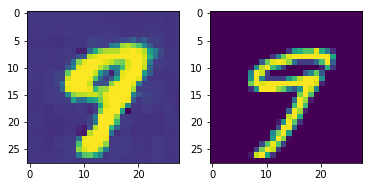

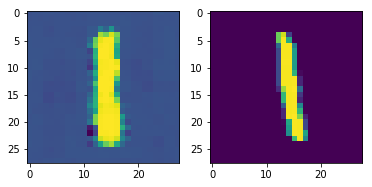

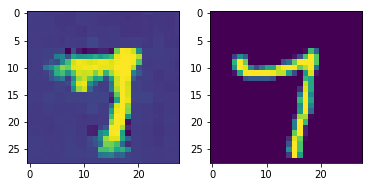

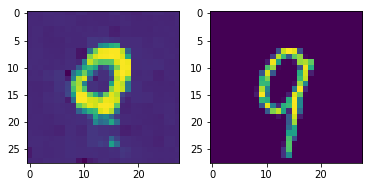

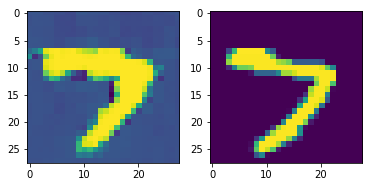

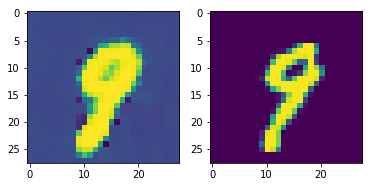

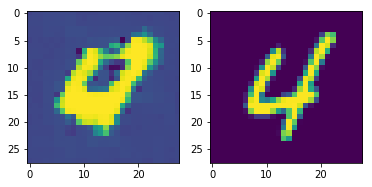

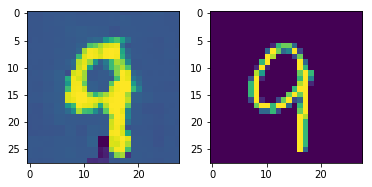

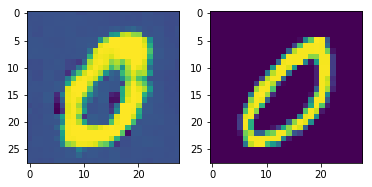

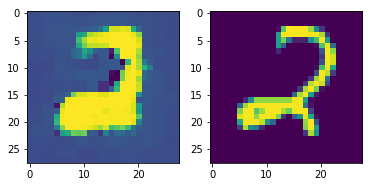

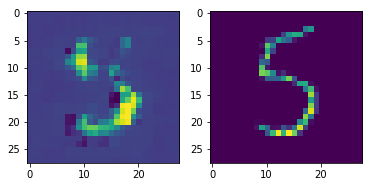

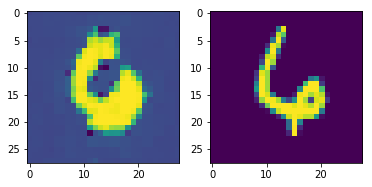

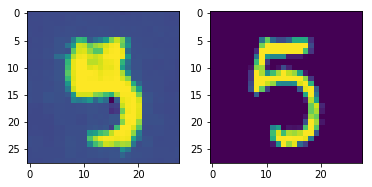

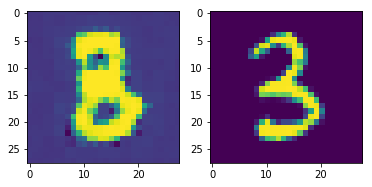

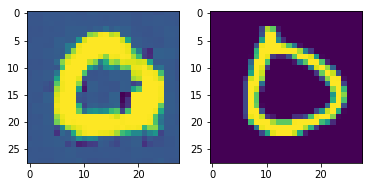

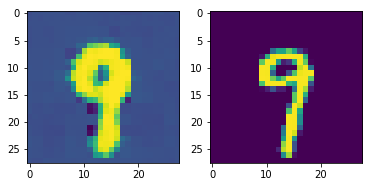

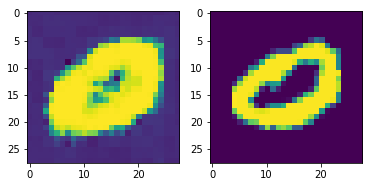

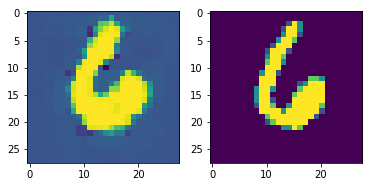

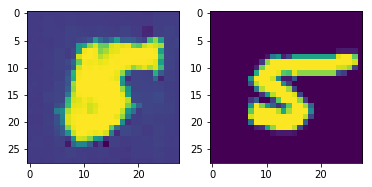

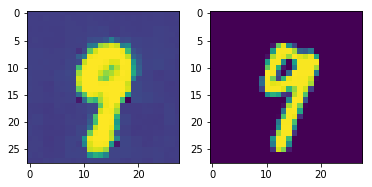

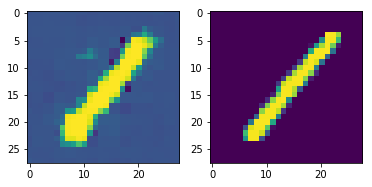

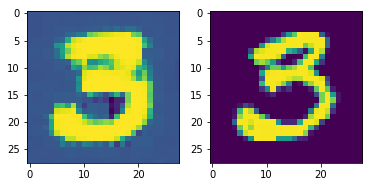

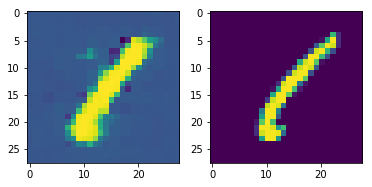

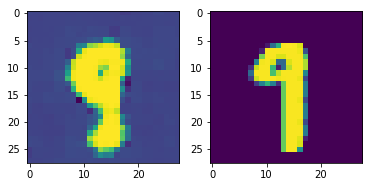

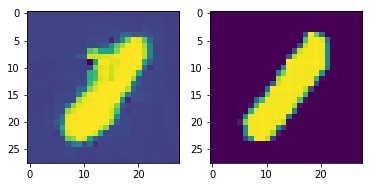

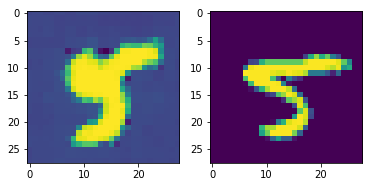

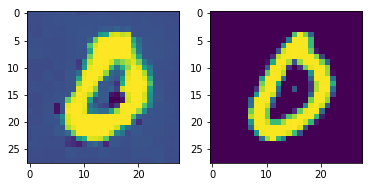

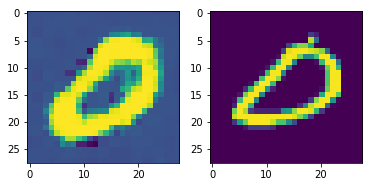

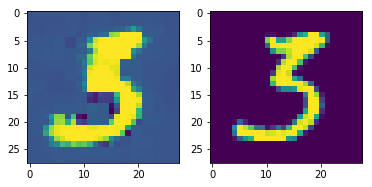

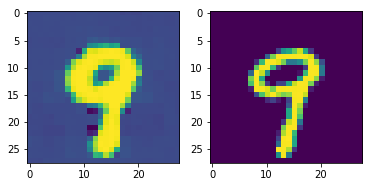

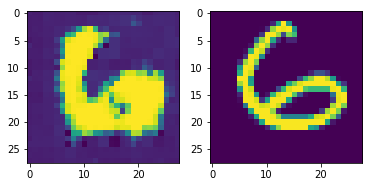

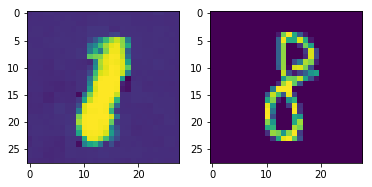

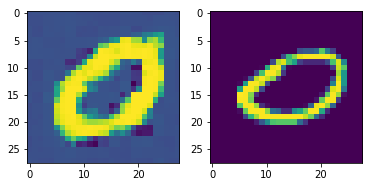

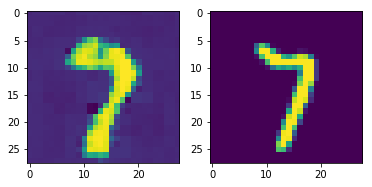

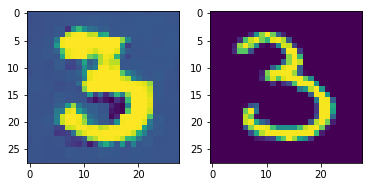

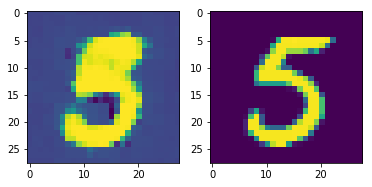

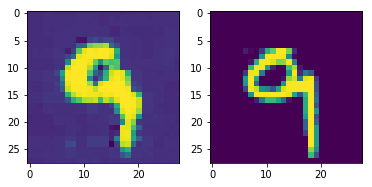

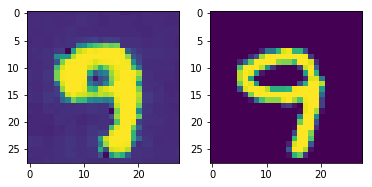

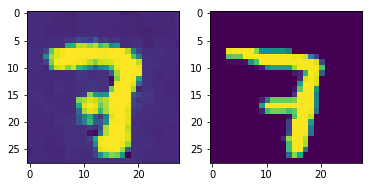

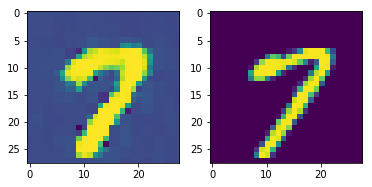

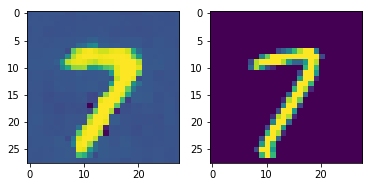

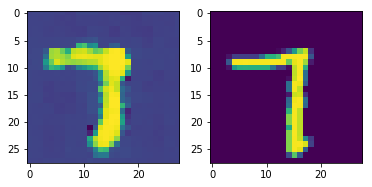

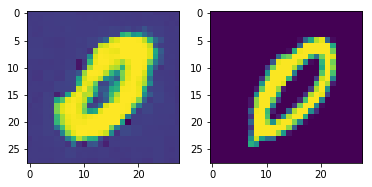

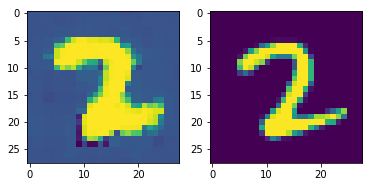

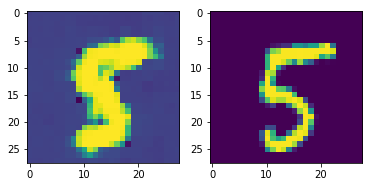

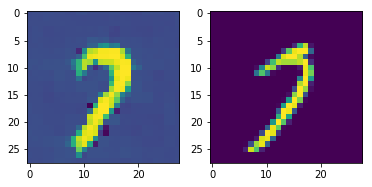

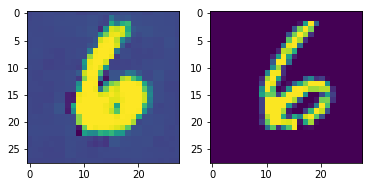

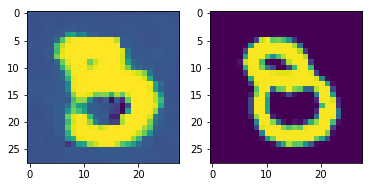

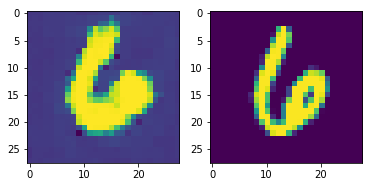

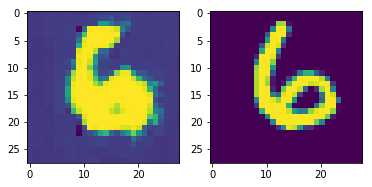

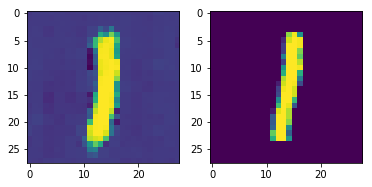

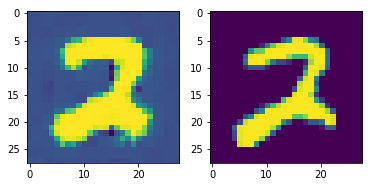

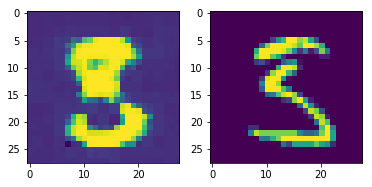

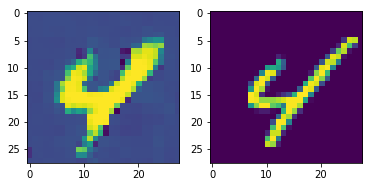

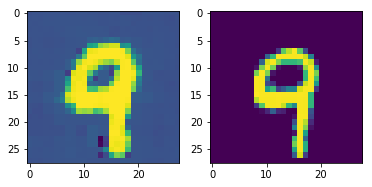

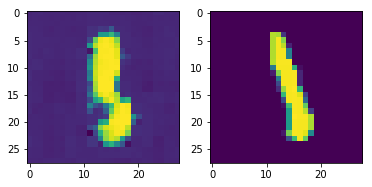

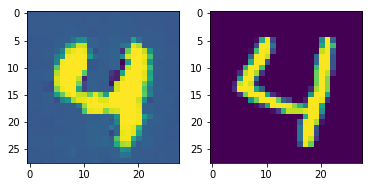

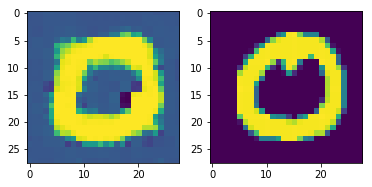

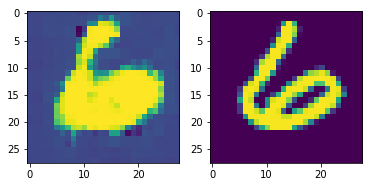

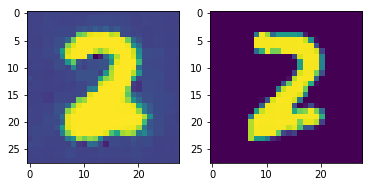

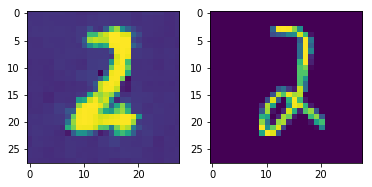

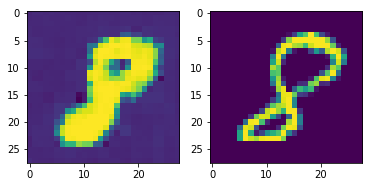

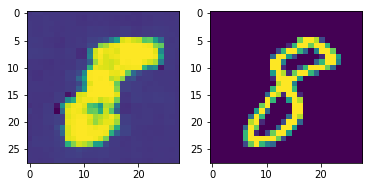

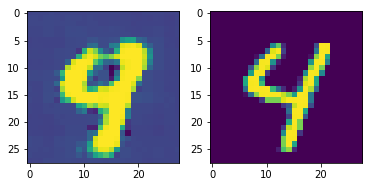

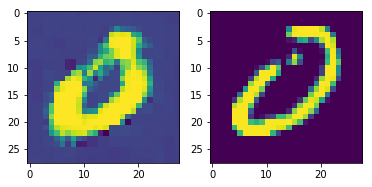

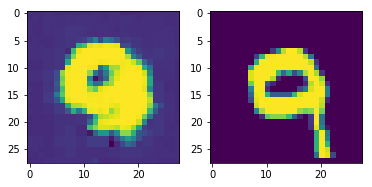

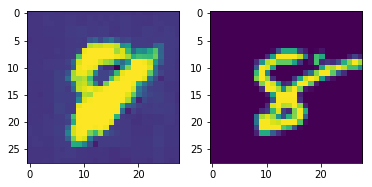

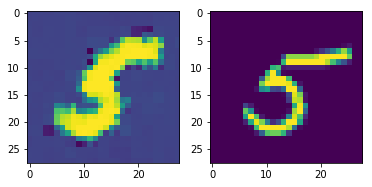

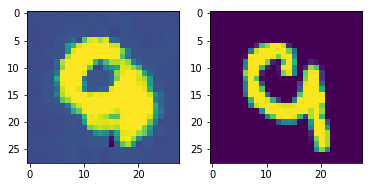

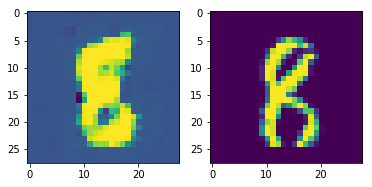

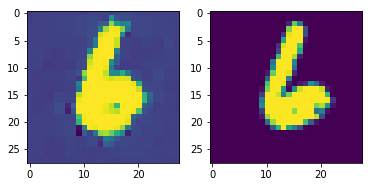

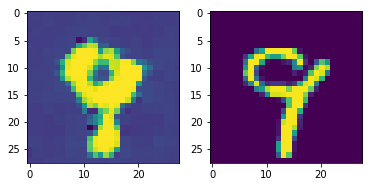

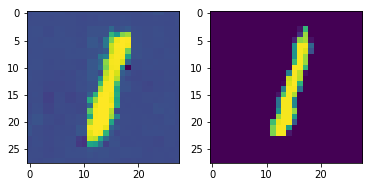

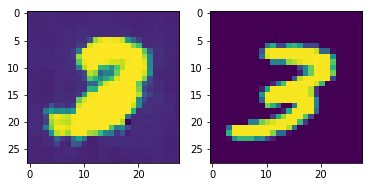

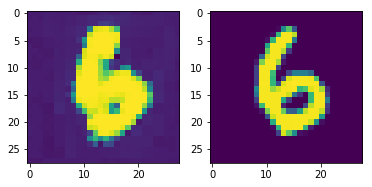

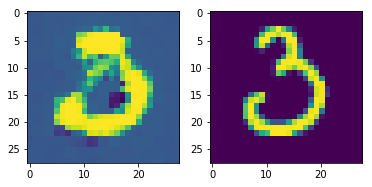

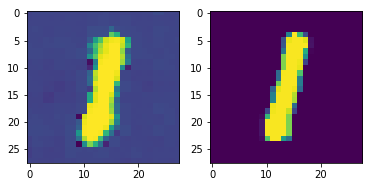

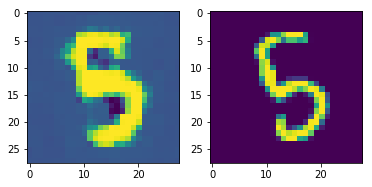

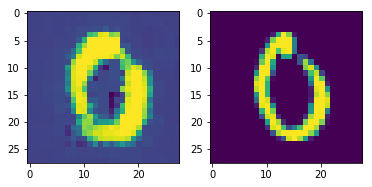

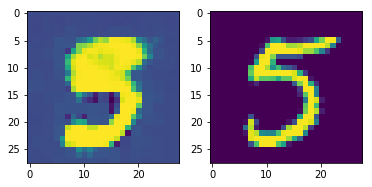

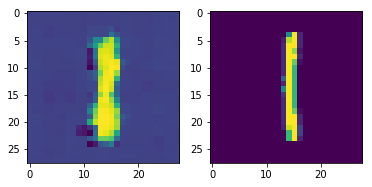

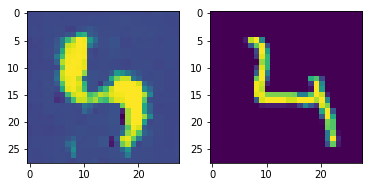

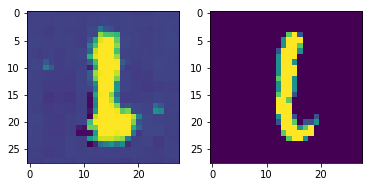

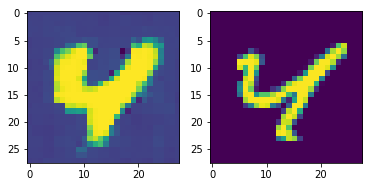

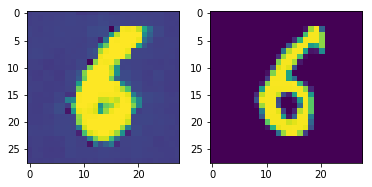

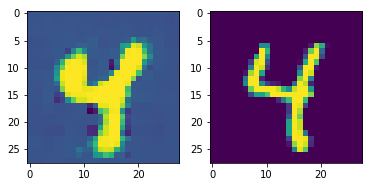

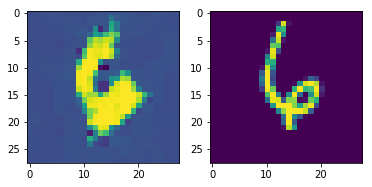

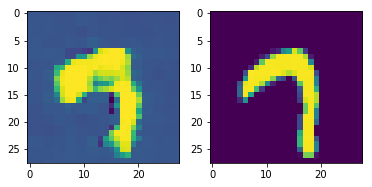

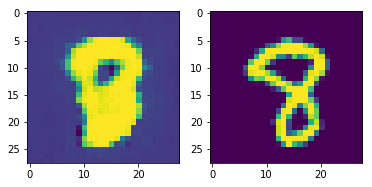

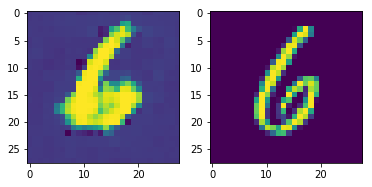

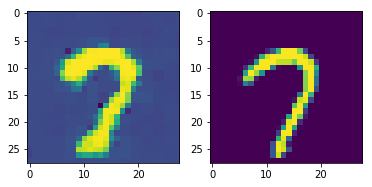

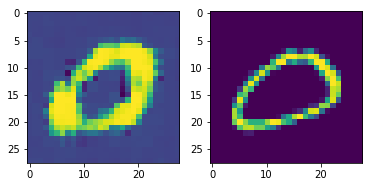

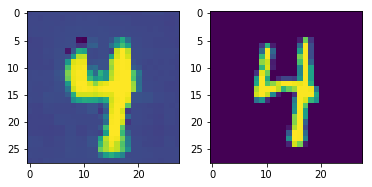

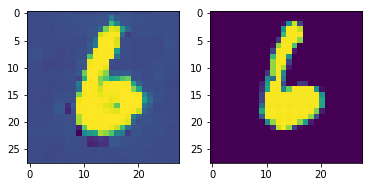

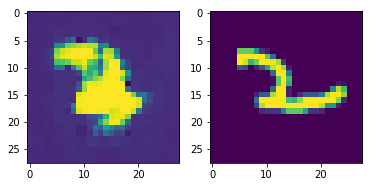

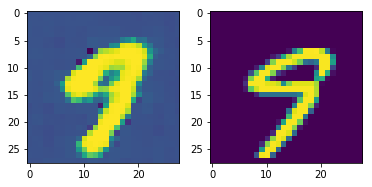

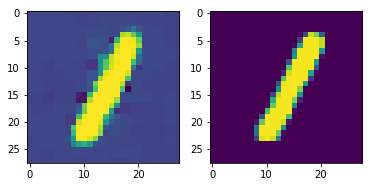

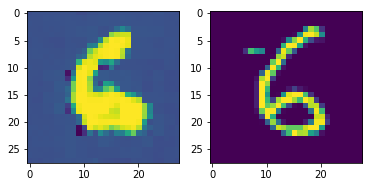

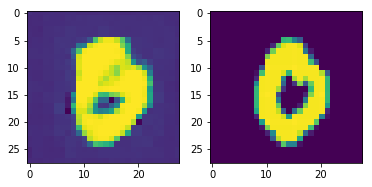

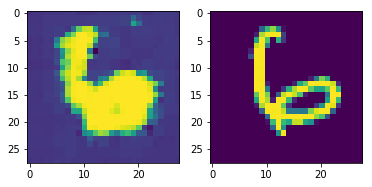

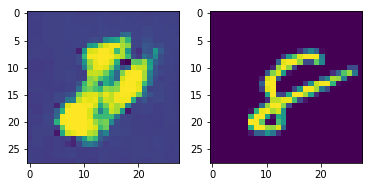

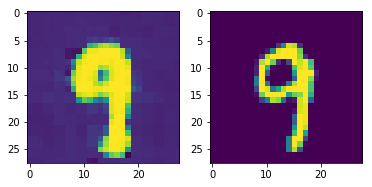

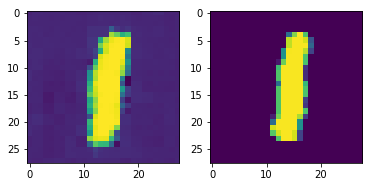

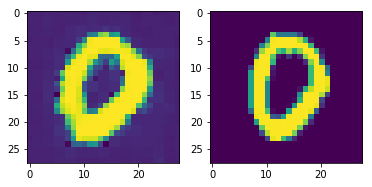

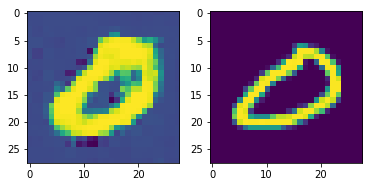

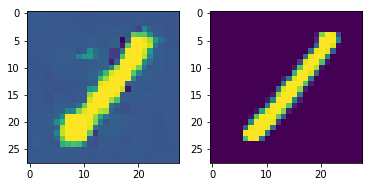

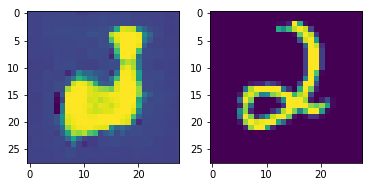

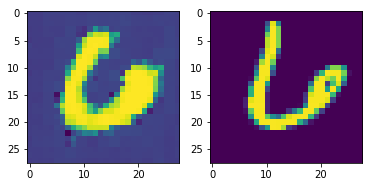

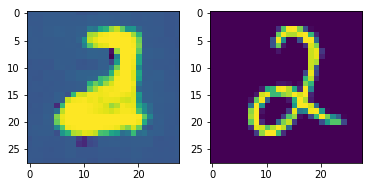

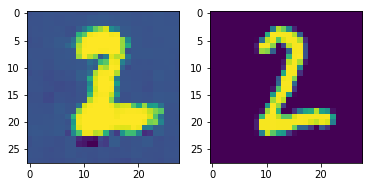

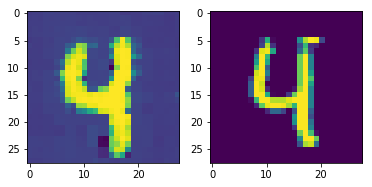

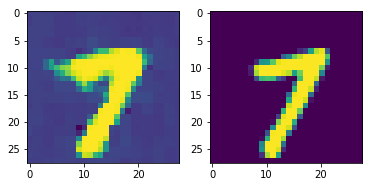

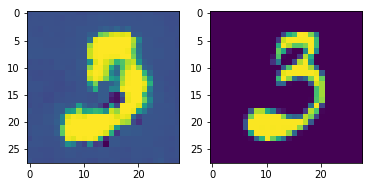

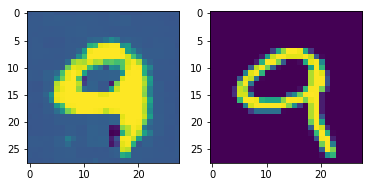

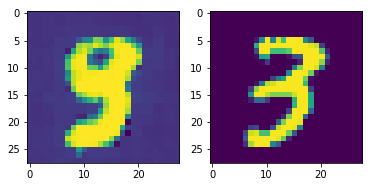

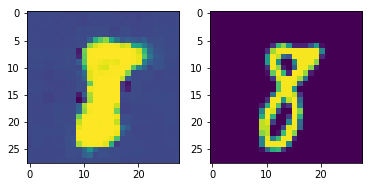

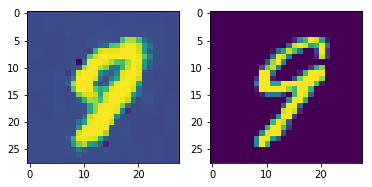

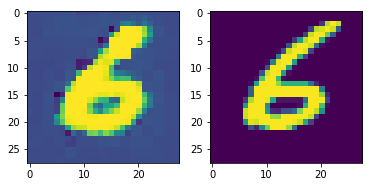

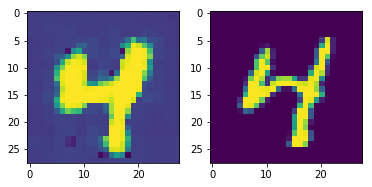

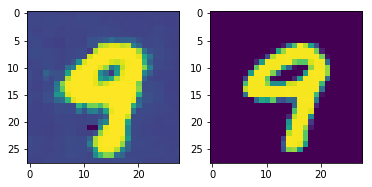

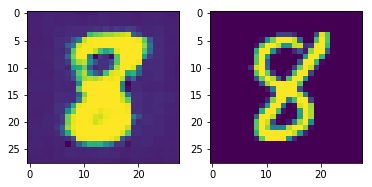

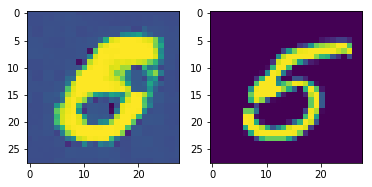

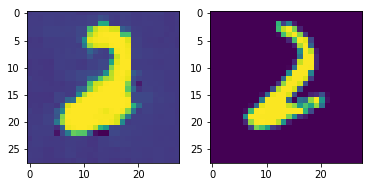

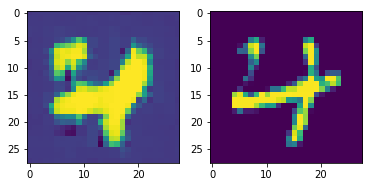

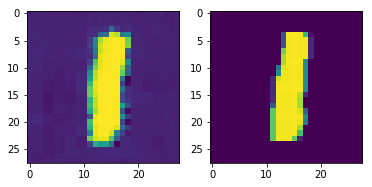

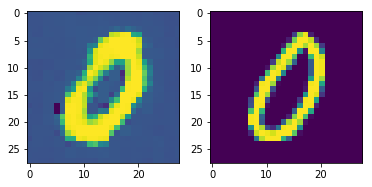

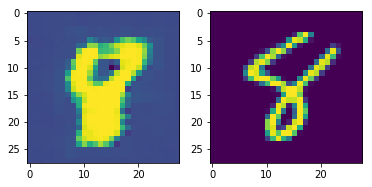

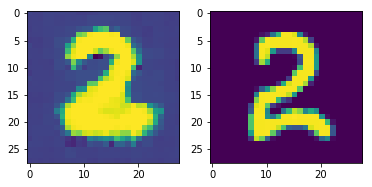

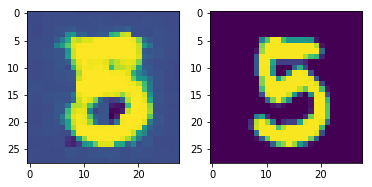

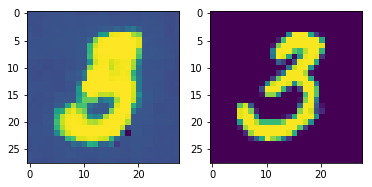

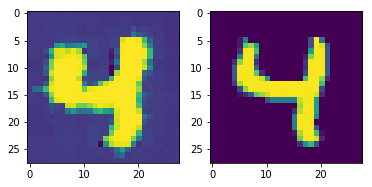

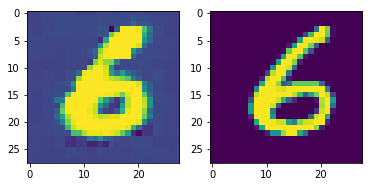

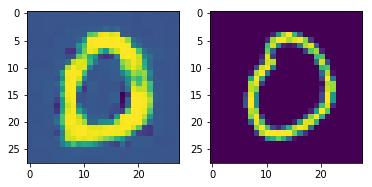

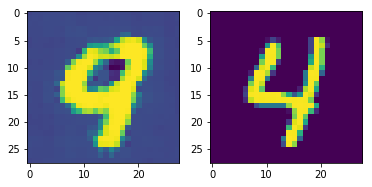

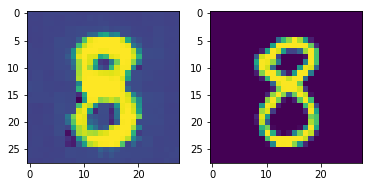

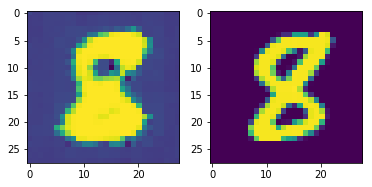

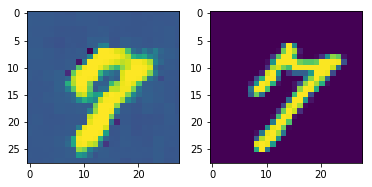

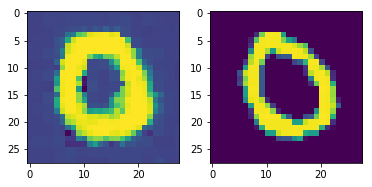

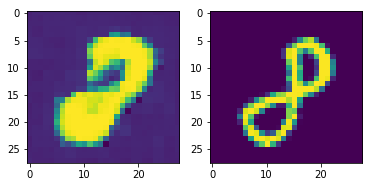

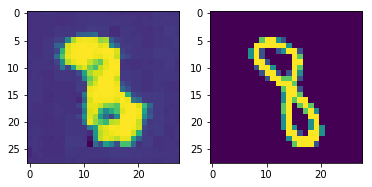

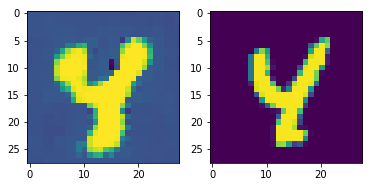

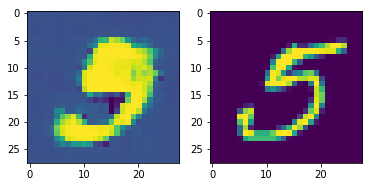

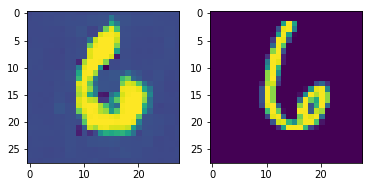

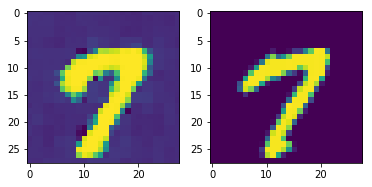

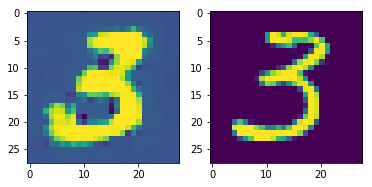

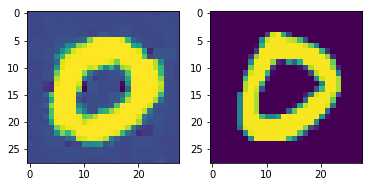

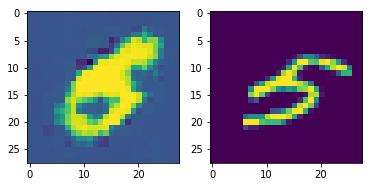

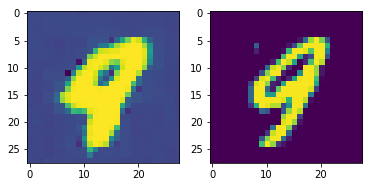

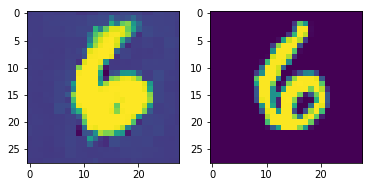

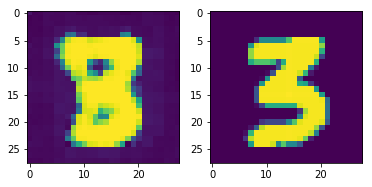

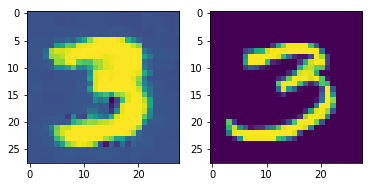

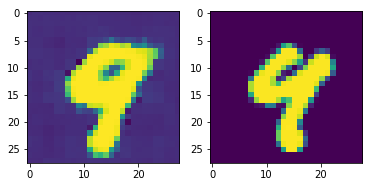

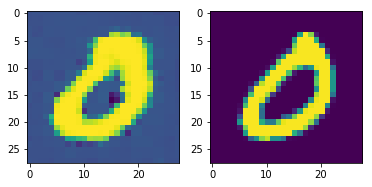

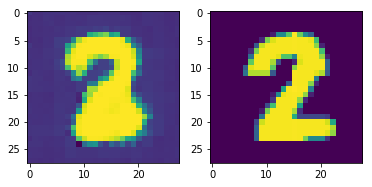

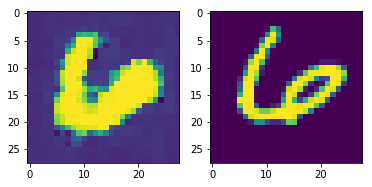

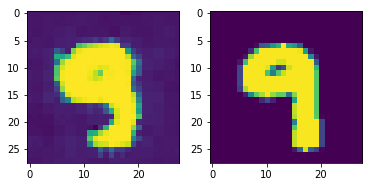

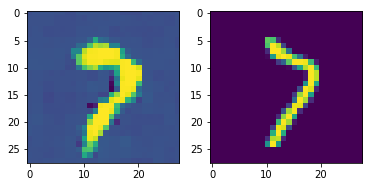

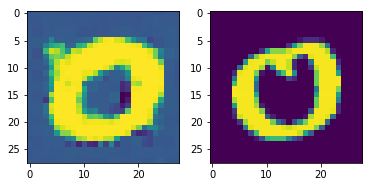

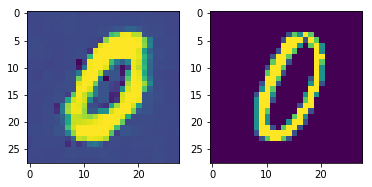

KeyboardInterrupt: 

In [22]:
for data, target in test_loader:
    result = autoencoder(data.to(device))
    result = result.cpu().detach().numpy()
    for i in range(len(result)):
        plt.subplot(1, 2, 1)
        plt.imshow(result[i].reshape(28,28))
        plt.subplot(1, 2, 2)
        plt.imshow(data.cpu().detach().numpy()[i].reshape(28,28))
        
        plt.show()
    assert False

In [ ]:
model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [44]:
def train(model, device, train_loader, optimizer, epoch):
    """Training"""
    model.train()
    for batch_idx, (data, target) in tqdm(enumerate(train_loader)):
        data, target = data.to(device), target.to(device)
#         data = autoencoder.encoder(data).view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 2**19 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            print('{{"metric": "Train - NLL Loss", "value": {}}}'.format(
        loss.item()))

In [88]:
def test(model, device, test_loader, epoch):
    """Testing"""
    model.eval()
    test_loss = 0
    correct = 0
    
    full_pred = []
    full_target = []
    full_data = []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            full_data.extend(data.to('cpu').detach().numpy())
            full_pred.extend(pred.detach().numpy())
            full_target.extend(target.detach().numpy())

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    print('{{"metric": "Eval - NLL Loss", "value": {}, "epoch": {}}}'.format(
        test_loss, epoch))
    print('{{"metric": "Eval - Accuracy", "value": {}, "epoch": {}}}'.format(
        100. * correct / len(test_loader.dataset), epoch))
    
    return full_target, full_pred, full_data

In [68]:
for epoch in range(5):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader, epoch)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.110375
{"metric": "Train - NLL Loss", "value": 0.11037468910217285}

Test set: Average loss: 0.0207, Accuracy: 9931/10000 (99%)

{"metric": "Eval - NLL Loss", "value": 0.02070217583179474, "epoch": 0}
{"metric": "Eval - Accuracy", "value": 99.31, "epoch": 0}


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.000167
{"metric": "Train - NLL Loss", "value": 0.00016695261001586914}

Test set: Average loss: 0.0203, Accuracy: 9931/10000 (99%)

{"metric": "Eval - NLL Loss", "value": 0.020277277135849, "epoch": 1}
{"metric": "Eval - Accuracy", "value": 99.31, "epoch": 1}


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.000415
{"metric": "Train - NLL Loss", "value": 0.0004150867462158203}

Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99%)

{"metric": "Eval - NLL Loss", "value": 0.02099664602279663, "epoch": 2}
{"metric": "Eval - Accuracy", "value": 99.29, "epoch": 2}


HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.000014
{"metric": "Train - NLL Loss", "value": 1.4483928680419922e-05}


KeyboardInterrupt: 

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.5/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [90]:
target, pred, full_data = test(model, device, test_loader, 0)


Test set: Average loss: 0.0181, Accuracy: 9940/10000 (99%)

{"metric": "Eval - NLL Loss", "value": 0.01809222071170807, "epoch": 0}
{"metric": "Eval - Accuracy", "value": 99.4, "epoch": 0}


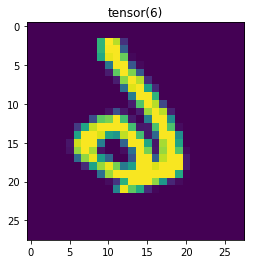

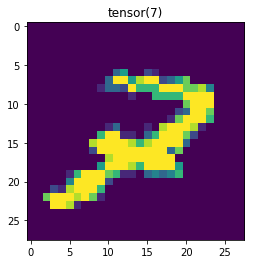

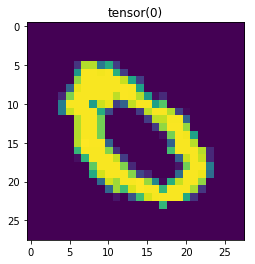

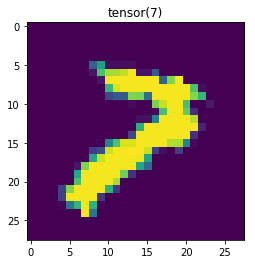

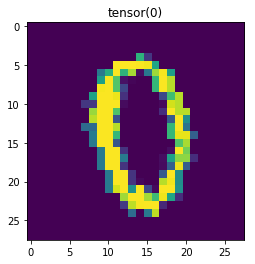

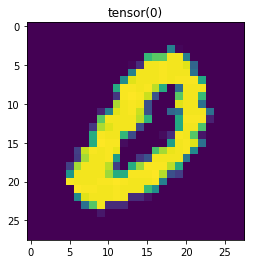

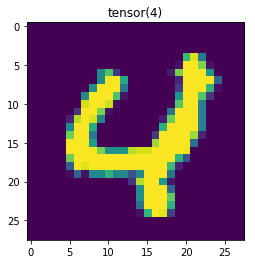

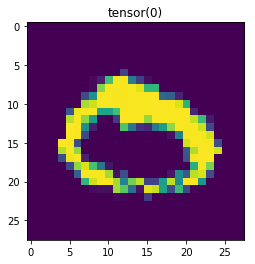

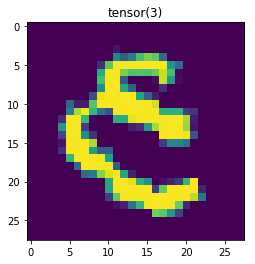

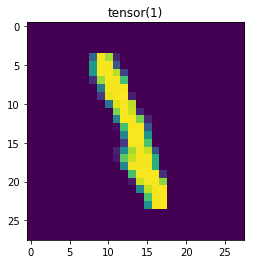

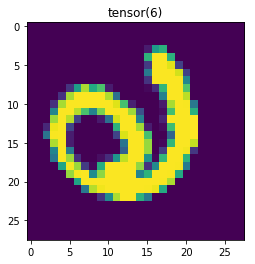

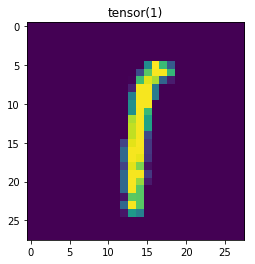

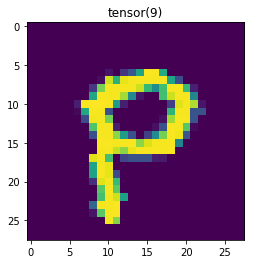

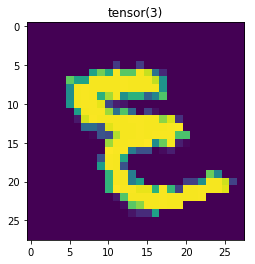

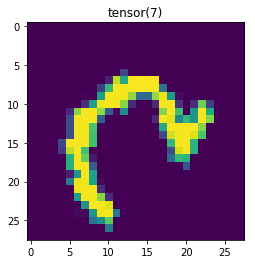

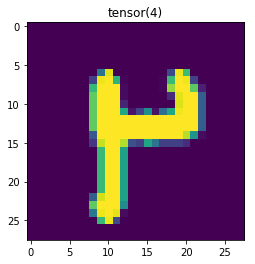

In [65]:
for data, target in train_loader:
    for vec, tar in zip(data, target):
        plt.figure()
        plt.imshow(vec.view(28, -1).numpy())
        plt.title(tar)
    break

In [106]:
a = full_data[0].flatten()

In [108]:
a.reshape((28,28))

array([[-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296],
       [-0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.42421296, -0.42421296, -0.42421296, -0.42421296,
        -0.42421296, -0.4242

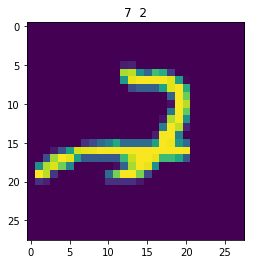

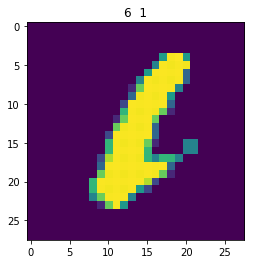

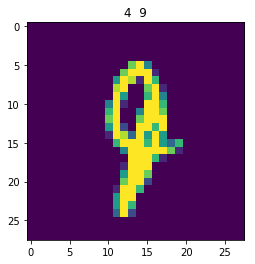

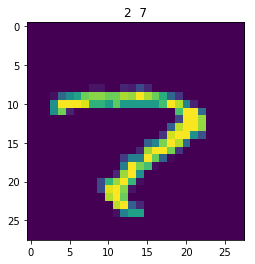

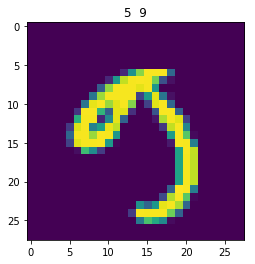

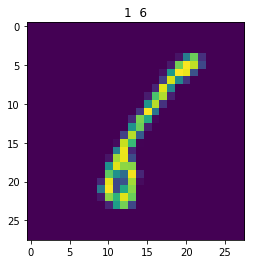

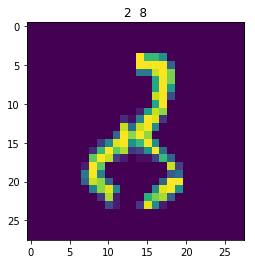

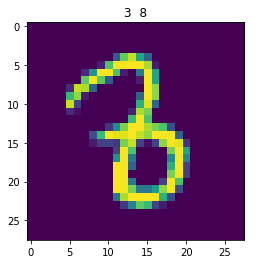

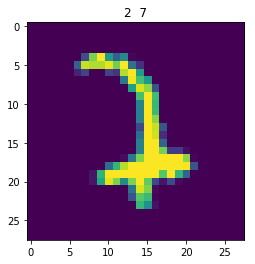

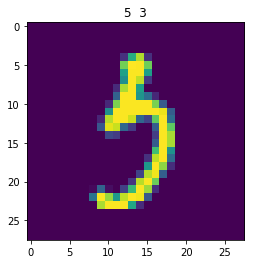

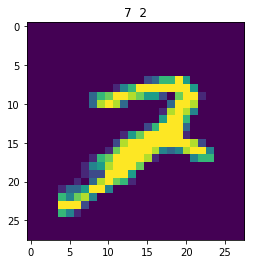

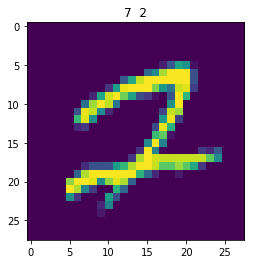

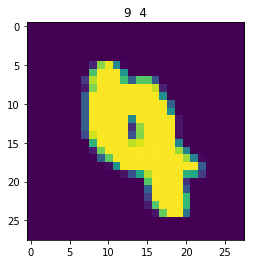

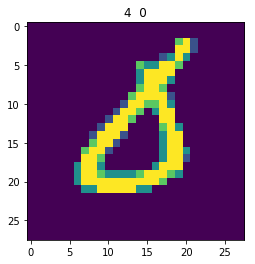

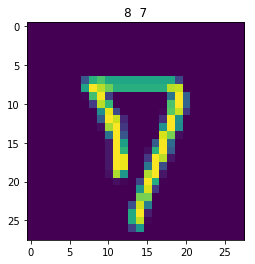

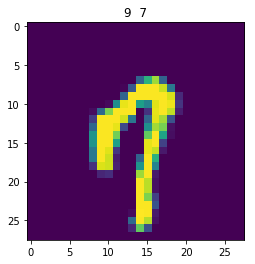

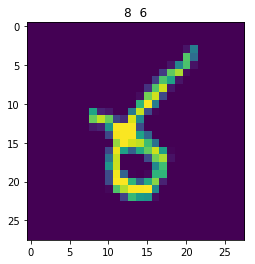

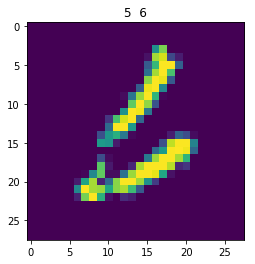

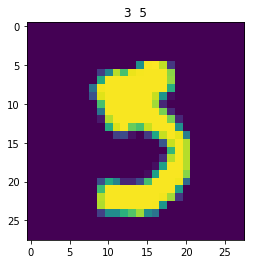

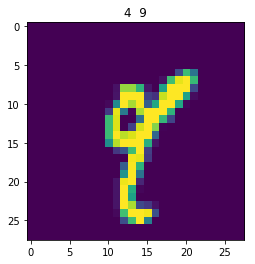

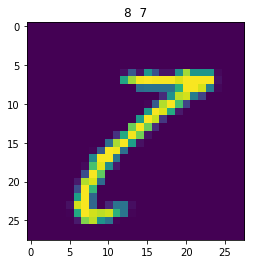

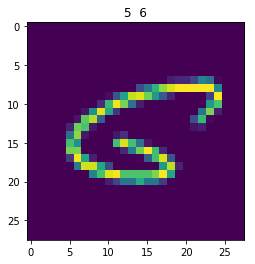

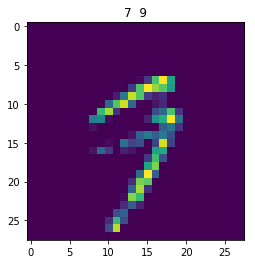

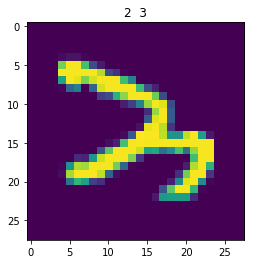

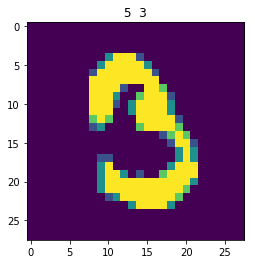

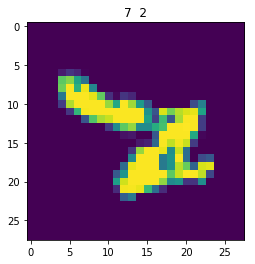

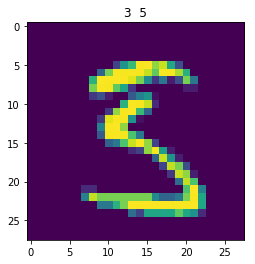

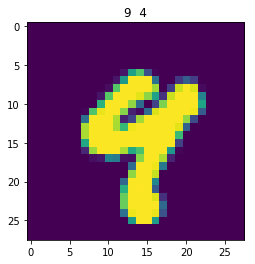

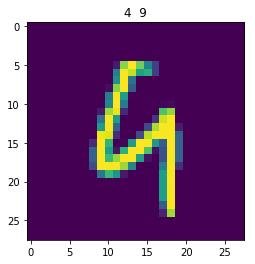

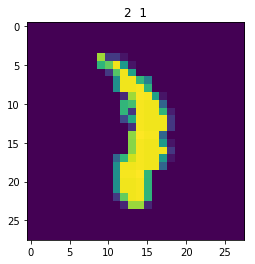

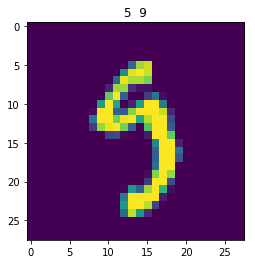

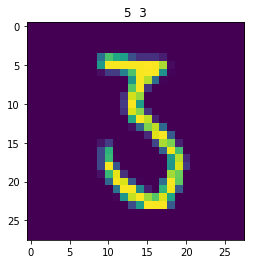

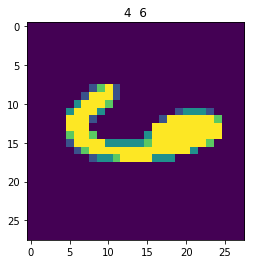

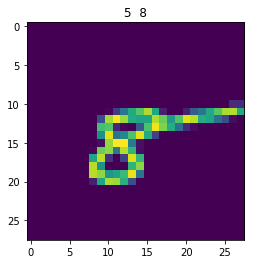

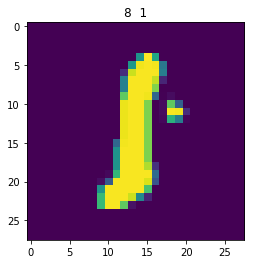

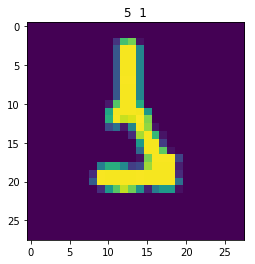

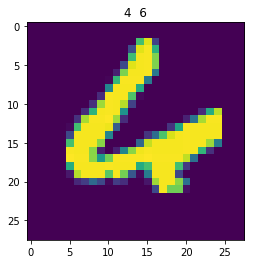

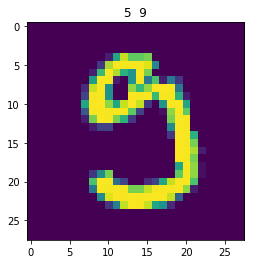

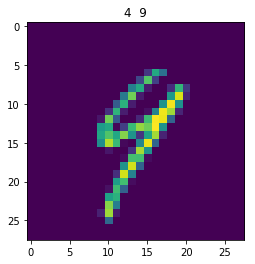

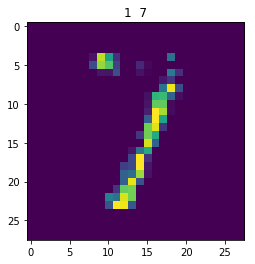

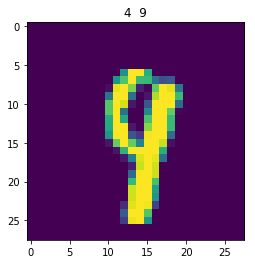

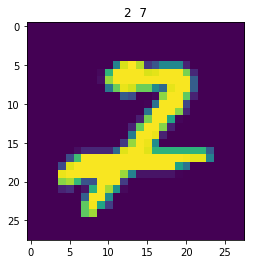

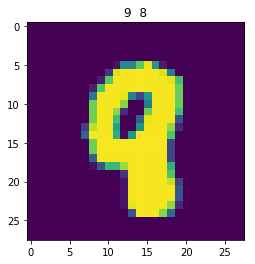

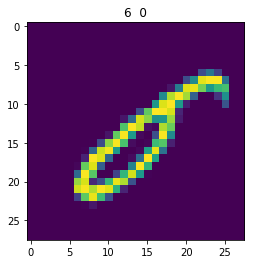

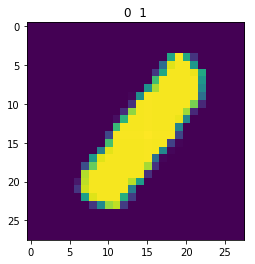

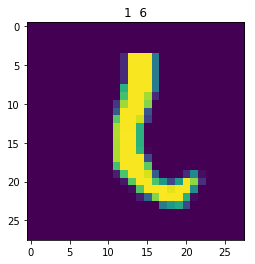

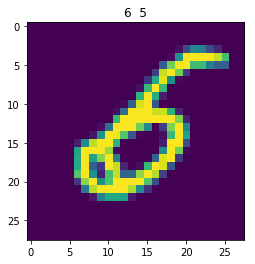

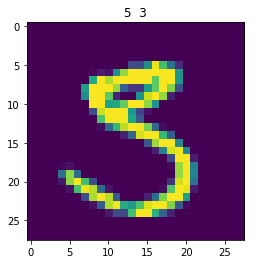

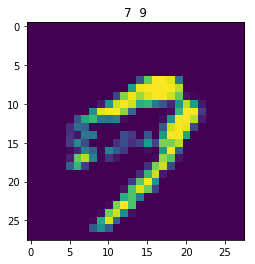

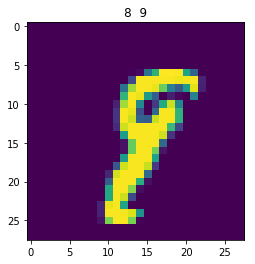

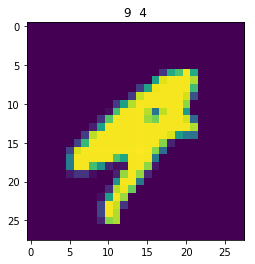

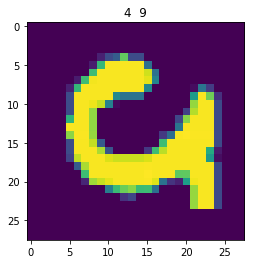

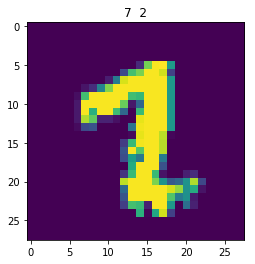

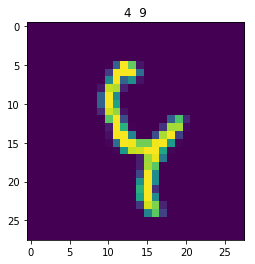

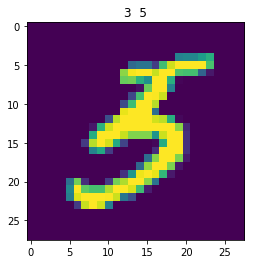

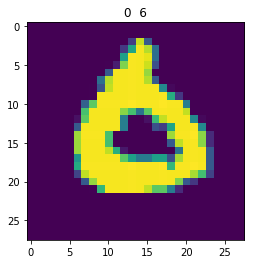

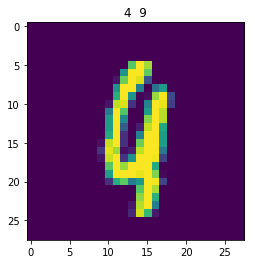

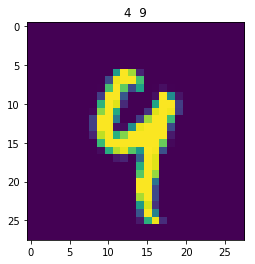

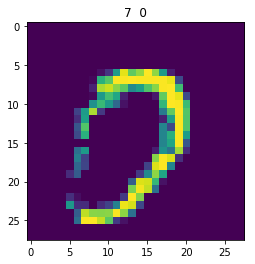

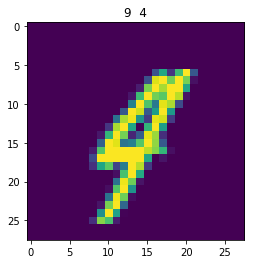

In [110]:
for i, (tar, pre, data) in enumerate(zip(target, pred, full_data)):
    pre = pre[0]
    if tar == pre:
        continue
        
    plt.figure()
    plt.imshow(data.flatten().reshape((28,28)))
    plt.title(str(pre) + '  ' +  str(tar))
    plt.show()

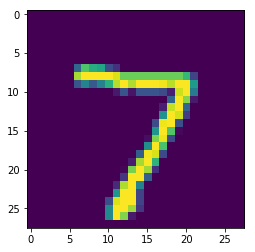

In [26]:
plt.imshow(test_loader.dataset[0][0].view(28, -1).numpy())

In [34]:
test_loader.dataset[0][1].view(-1).numpy()

array([7])